# Triton Server Image Recognition Workflow

In [1]:
import random
import tritonclient.grpc as grpcclient
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import time
from tqdm.auto import tqdm
import ipyplot

from utils import *
from bbox import *

# RedisDB for saving inference data

## Model Overview
```python
class Bbox(JsonModel):
    x1: int
    y1: int
    x2: int
    y2: int


class Face(JsonModel):
    bbox: Bbox
    probability: int
    label: Optional[int] = None
    rotation: Optional[int] = None
    descriptors: Optional[Dict] = None


class Model(JsonModel):
    filename: str = Field(index=True, full_text_search=True)
    faces: Optional[List[Face]] = None
    channels: Optional[int] = None
    height: Optional[int] = None
    width: Optional[int] = None
    portrait: Optional[int] = None

    class Meta:
        database = get_redis_connection()
```

In [2]:
load_dotenv()
Migrator().run()

query = CONTAINER_IMAGE_FOLDER.split("/")[1]

In [3]:
delete = Model.find(Model.filename % query).all()
for r in tqdm(delete, desc="Deleting existing keys"):
    try:
        Model.delete(r.pk)
    except Exception as e:
        print("There was an exception with {}\n{}".format(r, e))

formats = (".jpg", ".jpeg", ".png")
filenames = index_directory(CONTAINER_IMAGE_FOLDER, formats=formats)[:128]

for filename in tqdm(filenames, desc="Writing filenames to redis db."):
    try:
        Model(filename=filename).save()
    except Exception as e:
        print("There was an exception with {}\n{}".format(filename, e))

models = Model.find(Model.filename % query).all()

Deleting existing keys:   0%|          | 0/128 [00:00<?, ?it/s]

Writing filenames to redis db.:   0%|          | 0/128 [00:00<?, ?it/s]

# FaceDetect Model

## Model Overview <a class="anchor" name="model_overview"></a>

The model described in this card detects one or more faces in the given image / video. Compared to the FaceirNet model, this model gives better results on RGB images and smaller faces.

## Model Architecture <a class="anchor" name="model_architecture"></a>

The model is based on NVIDIA DetectNet_v2 detector with ResNet18 as a feature extractor. This architecture, also known as GridBox object detection, uses bounding-box regression on a uniform grid on the input image. Gridbox system divides an input image into a grid which predicts four normalized bounding-box parameters (xc, yc, w, h) and confidence value per output class.

The raw normalized bounding-box and confidence detections needs to be post-processed by a clustering algorithm such as DBSCAN or NMS to produce final bounding-box coordinates and category labels.

In [4]:
facedetect_client = TritonClient(
    model_name=FACE_DETECT_MODEL_NAME,
    model_version=MODEL_VERSION,
    url=TRITON_SERVER_URL,
    verbose=False,
)

rmi = RedisModelIterator(models, THREAD_CHUNKS)

In [5]:
est_total = (len(models) // THREAD_CHUNKS) + 1
pbar = tqdm(
    total=est_total,
    desc="Submitting photos to {} at {}".format(
        FACE_DETECT_MODEL_NAME, TRITON_SERVER_URL
    ),
)

facedetect_exceptions = []
with ThreadPoolExecutor(max_workers=THREAD_CHUNKS) as executor:
    for model_batch, image_batch in rmi:
        futures = []
        futures.append(
            executor.submit(facedetect_client.test_infer, model_batch, image_batch)
        )

        for future in as_completed(futures):
            infer_results = future.result()

            for infer_result in infer_results:
                try:
                    model = Model.get(infer_result.get_response().id)
                    image_wise_bboxes = infer_result.as_numpy(
                        facedetect_client.output_names[0]
                    ).reshape(-1, 4)
                    image_probas = infer_result.as_numpy(
                        facedetect_client.output_names[1]
                    ).reshape(-1, 1)
                    h, w, c = infer_result.as_numpy(
                        facedetect_client.output_names[2]
                    ).squeeze()
                    model.channels = int(c)
                    model.height = int(h)
                    model.width = int(w)
                    model.portrait = int(h > w)
                    for bbox, proba in zip(image_wise_bboxes, image_probas):
                        model.faces = [
                            {
                                "bbox": {
                                    "x1": int(round(bbox[0], 0)),
                                    "y1": int(round(bbox[1], 0)),
                                    "x2": int(round(bbox[2], 0)),
                                    "y2": int(round(bbox[3], 0)),
                                },
                                "probability": int(round(proba[0], 0)),
                            }
                            for bbox, proba in zip(image_wise_bboxes, image_probas)
                        ]
                    model.save()

                except BaseException as e:
                    try:
                        facedetect_exceptions.append(infer_result.message())
                    except:
                        facedetect_exceptions.append(e)

        pbar.update()

assert len(facedetect_exceptions) == 0

Submitting photos to facenet_ensemble at 172.25.4.42:8001:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
set(facedetect_exceptions)

set()

Looks like /volume1/brandon/pictures/1989-2011-pics-of-james-tuttle/alice-jim-color-photo.jpeg has 2 faces.

{'pk': '01GKMTCGJZGCYAK60FRHB442MW', 'filename': '/volume1/brandon/pictures/1989-2011-pics-of-james-tuttle/alice-jim-color-photo.jpeg', 'faces': [{'pk': '01GKMTCS5M3075T2STCPFZ4W1M', 'bbox': {'pk': '01GKMTCS5MJGBBXC00Y2JHDXSG', 'x1': 293, 'y1': 306, 'x2': 471, 'y2': 525}, 'probability': 43, 'label': None, 'rotation': None, 'descriptors': None}, {'pk': '01GKMTCS5MNKSCNB5MRQQD9P2S', 'bbox': {'pk': '01GKMTCS5M6Y2S8DTPGADDHPXC', 'x1': 605, 'y1': 111, 'x2': 796, 'y2': 371}, 'probability': 58, 'label': None, 'rotation': None, 'descriptors': None}], 'channels': 3, 'height': 693, 'width': 987, 'portrait': 0}


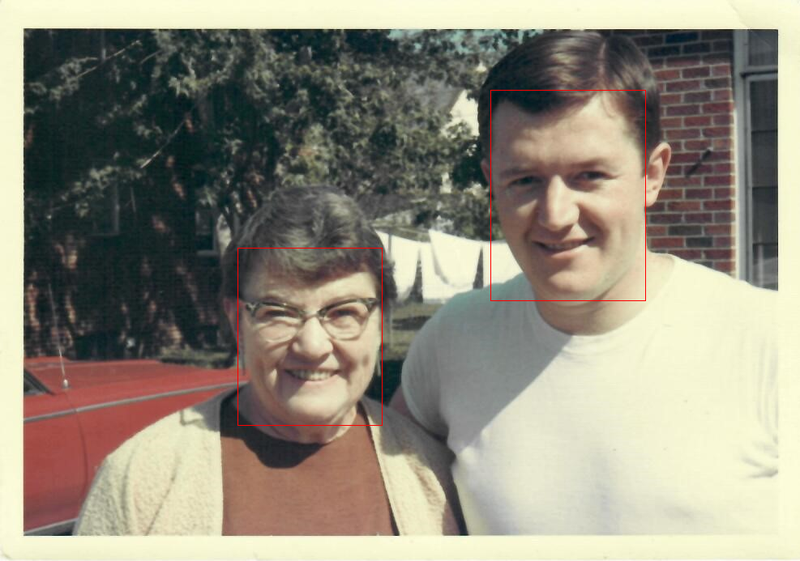

In [7]:
# Re-query since it's all been updated.
models = Model.find(Model.filename % query).all()
models = [model for model in models if model.faces]

for model in models:
    try:
        if len(model.faces) > 1:
            print(
                "Looks like {} has {} faces.\n".format(model.filename, len(model.faces))
            )
            break
        else:
            continue
    except BaseException:
        pass
print(model.dict())

render_image(model, output_size=800)

# Facial Landmark Estimator (FPENet) Model Card

## Model Overview <a class="anchor" name="model_overview"></a>

The FPENet model described in this card is a facial keypoints estimator network, which aims to predict the (x,y) location of keypoints for a given input face image. FPEnet is generally used in conjuction with a face detector and the output is commonly used for face alignment, head pose estimation, emotion detection, eye blink detection, gaze estimation, among others.

This model predicts 68, 80 or 104 keypoints for a given face- Chin: 1-17, Eyebrows: 18-27, Nose: 28-36, Eyes: 37-48, Mouth: 49-61, Inner Lips: 62-68, Pupil: 69-76, Ears: 77-80, additional eye landmarks: 81-104. It can also handle visible or occluded flag for each keypoint. An example of the kaypoints is shown as follows:

<img style="center" src="https://developer.nvidia.com/sites/default/files/akamai/TLT/fpe_sample_keypoints.png" width="500"> <br>

## Model Architecture <a class="anchor" name="model_architecture"></a>

This is a classification model with a [Recombinator network](https://openaccess.thecvf.com/content_cvpr_2016/papers/Honari_Recombinator_Networks_Learning_CVPR_2016_paper.pdf) backbone. Recombinator networks are a family of CNN architectures that are suited for fine grained pixel level predictions (as oppose to image level prediction like classification). The model recombines the layer inputs such that convolutional layers in the finer branches get inputs from both coarse and fine layers.

In [8]:
fpenet_client = TritonClient(
    model_name=FPENET_MODEL_NAME,
    model_version=MODEL_VERSION,
    url=TRITON_SERVER_URL,
    verbose=False,
)

rmi = RedisModelIterator(models, THREAD_CHUNKS)

In [9]:
est_total = (len(models) // THREAD_CHUNKS) + 1
pbar = tqdm(
    total=est_total,
    desc="Submitting photos to {} at {}".format(FPENET_MODEL_NAME, TRITON_SERVER_URL),
)

fpenet_exceptions = []
with ThreadPoolExecutor() as executor:
    for model_batch, image_batch in rmi:
        futures = []
        futures.append(
            executor.submit(fpenet_client.test_infer, model_batch, image_batch)
        )

        for future in as_completed(futures):
            infer_results = future.result()

            for infer_result in infer_results:
                try:
                    request_id = infer_result.get_response().id
                    model_pk, i = request_id.split("-")
                    model = Model.get(model_pk)
                    image_points = infer_result.as_numpy(
                        fpenet_client.output_names[1]
                    ).squeeze()
                    model.faces[int(i)].rotation = get_fpenet_rotation(image_points)
                    model.faces[int(i)].descriptors = parse_descriptors(image_points)
                    model.save()

                except BaseException as e:
                    try:
                        fpenet_exceptions.append(infer_result.message())
                    except:
                        fpenet_exceptions.append(e)

        pbar.update()

assert len(fpenet_exceptions) == 0

Submitting photos to fpenet_ensemble at 172.25.4.42:8001:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/utils.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  tan = (right_ys - left_ys) / (right_xs - left_xs)


In [10]:
set(fpenet_exceptions)

set()

Looks like /volume1/brandon/pictures/1989-2011-pics-of-james-tuttle/jim-darin-brandon-tanglewood-hawley-pa.jpeg has 3 faces.




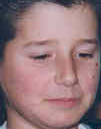
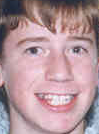
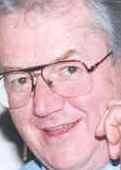


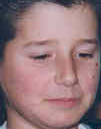
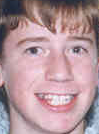
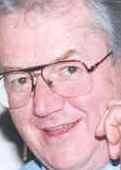


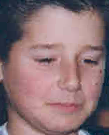
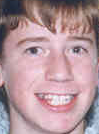
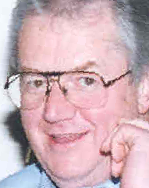


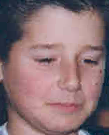
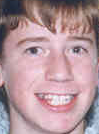
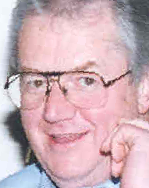

In [17]:
models = Model.find(Model.filename % query).all()
models = [model for model in models if model.faces]

for m in models:
    for face in m.faces:
        if (face.rotation) and (m.portrait == 0):
            model = m
            break


print("Looks like {} has {} faces.\n".format(model.filename, len(model.faces)))
original_crops = crop_and_rotate_clip(model)
# new_rotated_bbox is the function which applies the appropriate tranformation of the BBOX relative to the calculated rotation in degrees.
model_copy = model.copy(deep=True)
model_copy = new_rotated_bbox(model_copy)
modified_crops = crop_and_rotate_clip(model_copy, rotate=True)


ipyplot.plot_images(
    original_crops,
    labels=[
        "bbox #{}: 0\N{DEGREE SIGN} rotation".format(i)
        for i, face in enumerate(model.faces)
    ],
    show_url=False,
)
ipyplot.plot_images(
    modified_crops,
    labels=[
        "bbox #{}: {}\N{DEGREE SIGN} rotation".format(i, face.rotation)
        for i, face in enumerate(model_copy.faces)
    ],
    show_url=False,
)